In [1]:
from phoenix import sampling, actions_to_phase_space
from phoenix.potentials import miyamoto_nagai_potential, plummer_potential
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Disk distribution function

In [2]:
params = {
    "R0": 8.0, # for actions to phase space
    "Rinit": 8.0, # for sampling
    "R0": 5.0,
    "Rd": 2.5,
    "Sigma0": 100.0,
    "RsigR": 18.0,
    "RsigZ": 2.0,
    "sigmaR0_R0": 140.0,
    "sigmaz0_R0": 5.0,
    "L0": 50.0,
    "Rinit_for_Rc": 8.0,
}

envelope_max = 3.0
n_candidates = 250_000
key = jax.random.PRNGKey(42)

Phi_spheroid = miyamoto_nagai_potential
theta_spheroid = jnp.array([1e12, 60.0, 0.01]) # (M, a, b) z.B. für Miyamoto-Nagai

In [3]:
#Generate candidate actions
from phoenix.distributionfunctions_disky_Binney import f_disc_from_params
candidates, samples, soft_weights = sampling.sample_df_potential(f_disc_from_params, key, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, tau=0.01)
print("Number of candidate actions:", samples.shape[0])

#Map the candidate actions to phase-space coordinates
phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key, Phi_spheroid, theta_spheroid)
x = phase_space_coords[:, 0]
y = phase_space_coords[:, 1]
z = phase_space_coords[:, 2]
v_x = phase_space_coords[:, 3]
v_y = phase_space_coords[:, 4]
v_z = phase_space_coords[:, 5]


/Users/annalena/Documents/GitHub/phoenix/phoenix/distributionfunctions_disky_Binney.py:13: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite typechecker: usually one of the two lines below.
from typeguard import typechecked as typechecker
from beartype import beartype as typechecker

@jaxtyped(typechecker=typechecker)
def foo(...):
```
and the old double-decorator syntax
```
@jaxtyped
@typechecker
def foo(...):
```
should no longer be used. (It will continue to work as it did before, but the new approach will produce more readable error messages.)
In particular note that `typechecker` must be passed via keyword argument; the following is not valid:
```
@jaxtyped(typechecker)
def foo(...):
```

  @jaxtyped
/Users/annalena/Documents/GitHub/phoenix/phoenix/distributionfunctions_disky_Binney.py:37: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyp

Number of candidate actions: 250000


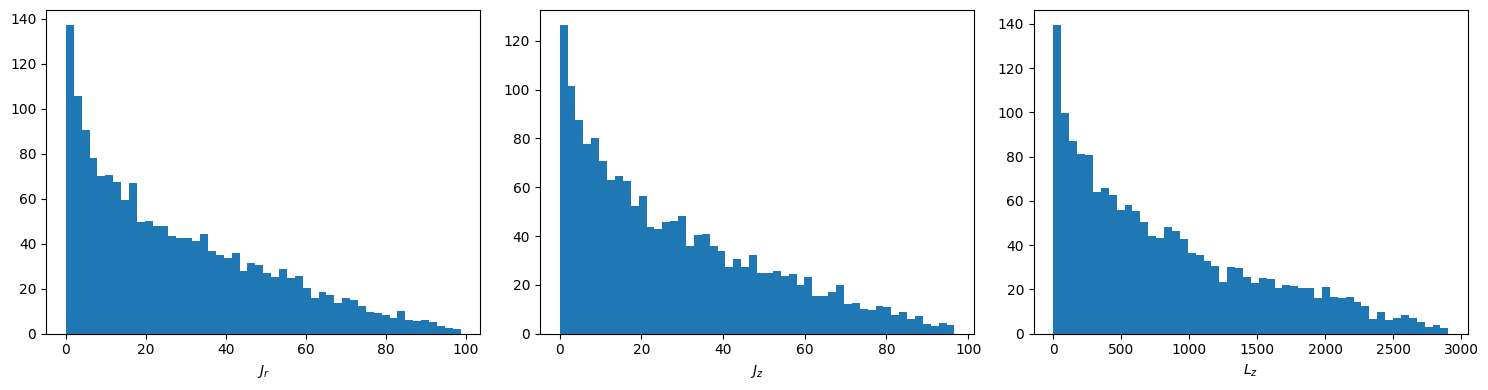

In [4]:
#Visualize the distribution of candidate actions
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].hist(samples[:, 0], bins=50, weights=soft_weights)
axs[0].set_xlabel(r"$J_r$")
axs[1].hist(samples[:, 1], bins=50, weights=soft_weights)
axs[1].set_xlabel(r"$J_z$")
axs[2].hist(samples[:, 2], bins=50, weights=soft_weights)
axs[2].set_xlabel(r"$L_z$")
plt.tight_layout()
plt.show()

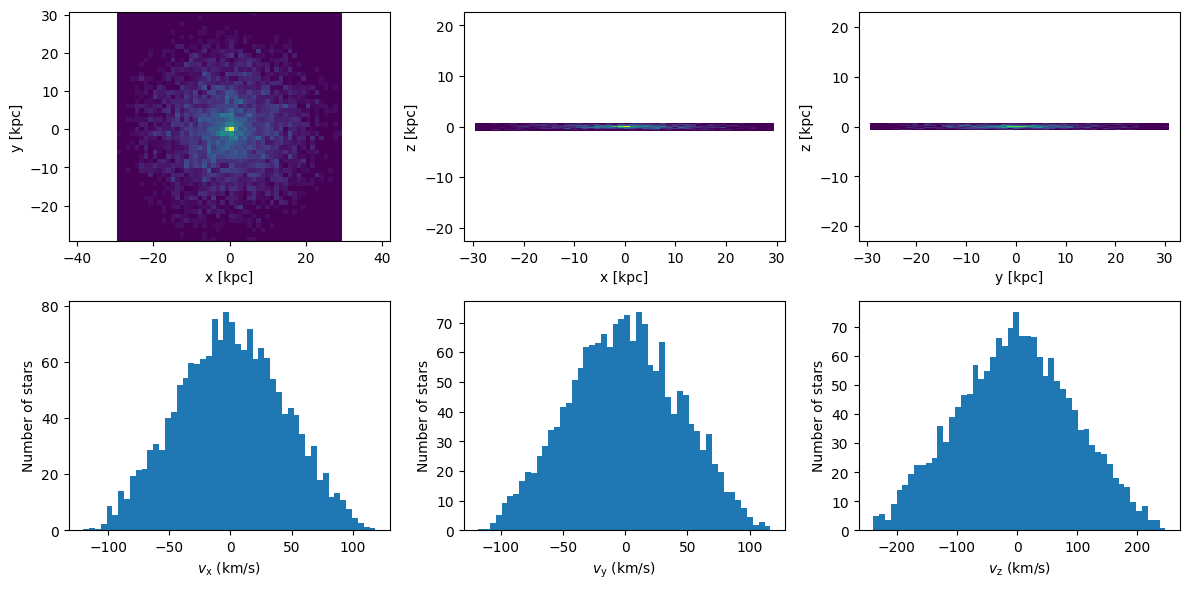

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.figure(figsize=(12,6))
plt.subplot(231)
plt.hist2d(x, y, bins=50, cmap="viridis", weights=soft_weights)#, norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.axis('equal')
plt.subplot(232)
plt.hist2d(x, z, bins=50, cmap="viridis", weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.subplot(233)
plt.hist2d(y, z, bins=50, cmap="viridis", weights=soft_weights)
plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')


plt.subplot(234)
plt.hist(v_x, bins=50, weights=soft_weights)#, range=(-2000, 2000))
plt.xlabel(r"$v_\text{x}$ (km/s)")
plt.ylabel("Number of stars")

plt.subplot(235)
plt.hist(v_y, bins=50, weights=soft_weights)#, range=(-2000, 2000))
plt.xlabel(r"$v_\text{y}$ (km/s)")
plt.ylabel("Number of stars")

plt.subplot(236)
plt.hist(v_z, bins=50, weights=soft_weights)
plt.xlabel(r"$v_\text{z}$ (km/s)")
plt.ylabel("Number of stars")
plt.tight_layout()
plt.show()

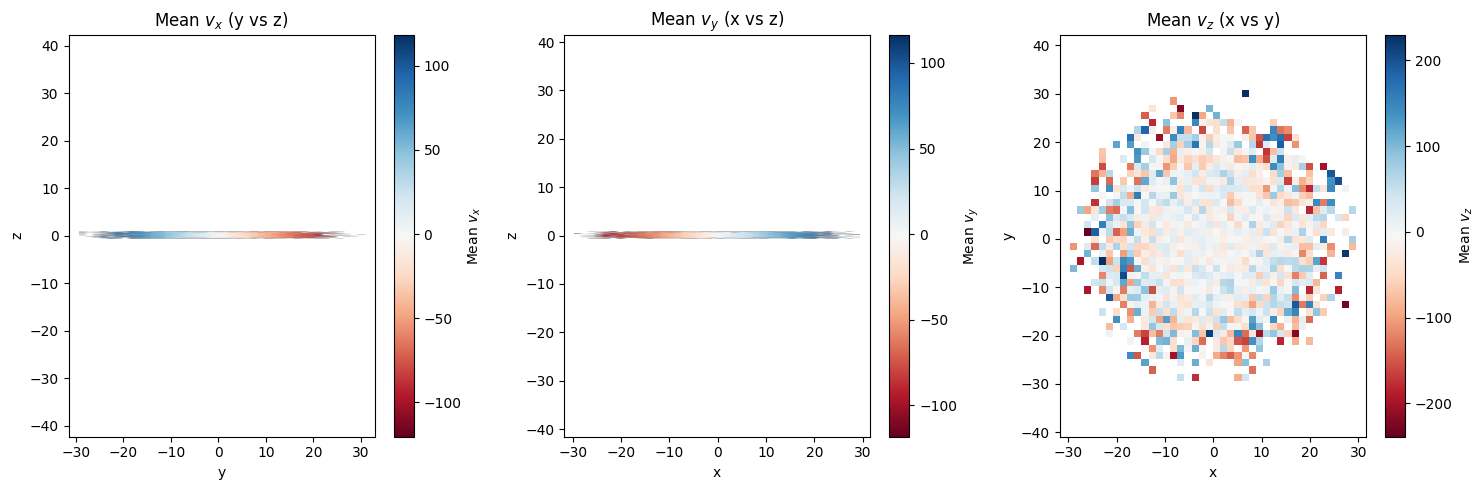

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import binned_statistic_2d

# Helper function to calculate weighted mean
def weighted_mean_2d(x_pos, y_pos, values, weights, x_bins, y_bins):
    # Sum of (value * weight) in each bin
    weighted_sum, _, _, _ = binned_statistic_2d(
        x_pos, y_pos, values * weights, statistic='sum', bins=[x_bins, y_bins]
    )
    # Sum of weights in each bin
    sum_of_weights, _, _, _ = binned_statistic_2d(
        x_pos, y_pos, weights, statistic='sum', bins=[x_bins, y_bins]
    )
    
    # Divide, handling division by zero (where sum_of_weights is 0)
    with np.errstate(divide='ignore', invalid='ignore'):
        result = weighted_sum / sum_of_weights
    
    return result

num_bins_x = 40
num_bins_y = 40
num_bins_z = 40 

# Example: x, z, v_y are 1D arrays of particle positions and velocities
# Define bin edges
x_bins = np.linspace(x.min(), x.max(), num_bins_x + 1)
y_bins = np.linspace(y.min(), y.max(), num_bins_x + 1)
z_bins = np.linspace(z.min(), z.max(), num_bins_z + 1)

# Digitize positions to bin indices
x_idx = np.digitize(x, x_bins) - 1
y_idx = np.digitize(y, y_bins) - 1
z_idx = np.digitize(z, z_bins) - 1

# Initialize array for mean v_y
mean_vx = np.full((num_bins_y, num_bins_z), np.nan)
mean_vy = np.full((num_bins_x, num_bins_z), np.nan)
mean_vz = np.full((num_bins_x, num_bins_y), np.nan)

# 1. Mean v_x (y vs z)
mean_vx = weighted_mean_2d(y, z, v_x, soft_weights, y_bins, z_bins)

# 2. Mean v_y (x vs z)
mean_vy = weighted_mean_2d(x, z, v_y, soft_weights, x_bins, z_bins)

# 3. Mean v_z (x vs y)
mean_vz = weighted_mean_2d(x, y, v_z, soft_weights, x_bins, y_bins)

        
# Plot mean velocity maps side-by-side (y vs z, x vs z, x vs y)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# mean_vx: y vs z
im0 = axs[0].imshow(mean_vx.T, origin='lower', aspect='auto',
                   extent=[y_bins[0], y_bins[-1], z_bins[0], z_bins[-1]],
                   cmap='RdBu')
axs[0].set_xlabel('y')
axs[0].set_ylabel('z')
axs[0].set_title('Mean $v_x$ (y vs z)')
axs[0].axis('equal')
plt.colorbar(im0, ax=axs[0], label='Mean $v_x$')
# mean_vy: x vs z
im1 = axs[1].imshow(mean_vy.T, origin='lower', aspect='auto',
                   extent=[x_bins[0], x_bins[-1], z_bins[0], z_bins[-1]],
                   cmap='RdBu')
axs[1].set_xlabel('x')
axs[1].set_ylabel('z')
axs[1].set_title('Mean $v_y$ (x vs z)')
axs[1].axis('equal')
plt.colorbar(im1, ax=axs[1], label='Mean $v_y$')
# mean_vz: x vs y
im2 = axs[2].imshow(mean_vz.T, origin='lower', aspect='auto',
                   extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
                   cmap='RdBu')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Mean $v_z$ (x vs y)')
plt.colorbar(im2, ax=axs[2], label='Mean $v_z$')
axs[2].axis('equal')
plt.tight_layout()
plt.show()

# Spheroid distribution function

In [7]:
params = {
    "R0": 8.0, # for actions to phase space
    "N0_spheroid": 1e6,
    "J0_spheroid": 50.0,
    "Gamma_spheroid": 2.5,
    "Beta_spheroid": 3.5,
}

envelope_max = 3.0
n_candidates = 250_000
key = jax.random.PRNGKey(42)
# Js are max 400, 400, 2000

Phi_spheroid = plummer_potential
theta_spheroid = jnp.array([1e12, 30.0]) # (M, a) z.B. für Plummer

In [8]:
#Generate candidate actions
from phoenix.distributionfunctions_spheroidal import f_double_power_law as df_spheroid
candidates, samples, soft_weights2 = sampling.sample_df_potential(df_spheroid, key, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, tau=0.01)
print("Number of candidate actions:", candidates.shape[0])

#Map the candidate actions to phase-space coordinates
phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key, Phi_spheroid, theta_spheroid)
x2 = phase_space_coords[:, 0]
y2 = phase_space_coords[:, 1]
z2 = phase_space_coords[:, 2]
v_x2 = phase_space_coords[:, 3]
v_y2 = phase_space_coords[:, 4]
v_z2 = phase_space_coords[:, 5]

/Users/annalena/Documents/GitHub/phoenix/phoenix/distributionfunctions_spheroidal.py:13: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite typechecker: usually one of the two lines below.
from typeguard import typechecked as typechecker
from beartype import beartype as typechecker

@jaxtyped(typechecker=typechecker)
def foo(...):
```
and the old double-decorator syntax
```
@jaxtyped
@typechecker
def foo(...):
```
should no longer be used. (It will continue to work as it did before, but the new approach will produce more readable error messages.)
In particular note that `typechecker` must be passed via keyword argument; the following is not valid:
```
@jaxtyped(typechecker)
def foo(...):
```

  @jaxtyped


Number of candidate actions: 250000


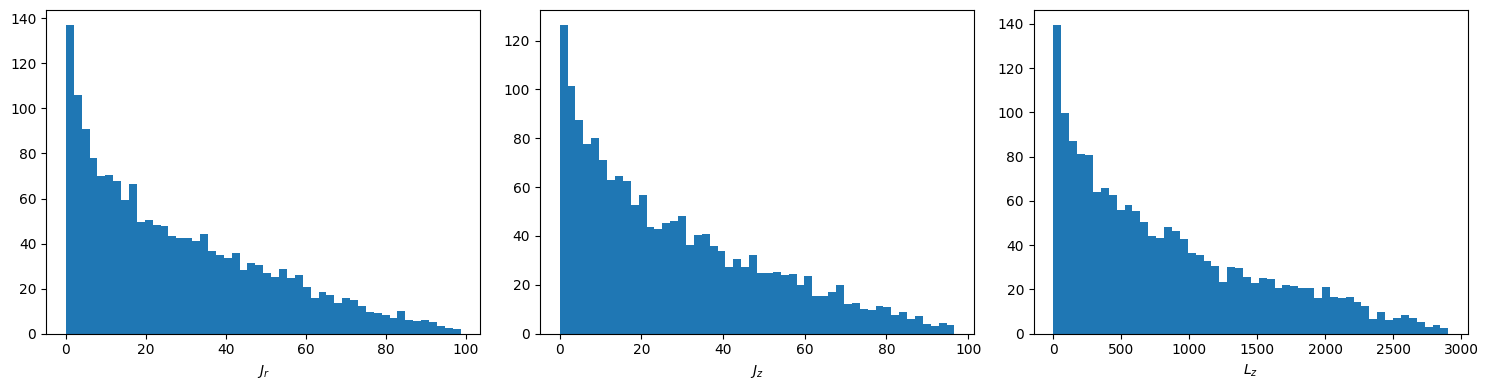

In [9]:
#Visualize the distribution of candidate actions
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].hist(samples[:, 0], bins=50, weights=soft_weights)
axs[0].set_xlabel(r"$J_r$")
axs[1].hist(samples[:, 1], bins=50, weights=soft_weights)
axs[1].set_xlabel(r"$J_z$")
axs[2].hist(samples[:, 2], bins=50, weights=soft_weights)
axs[2].set_xlabel(r"$L_z$")
plt.tight_layout()
plt.show()

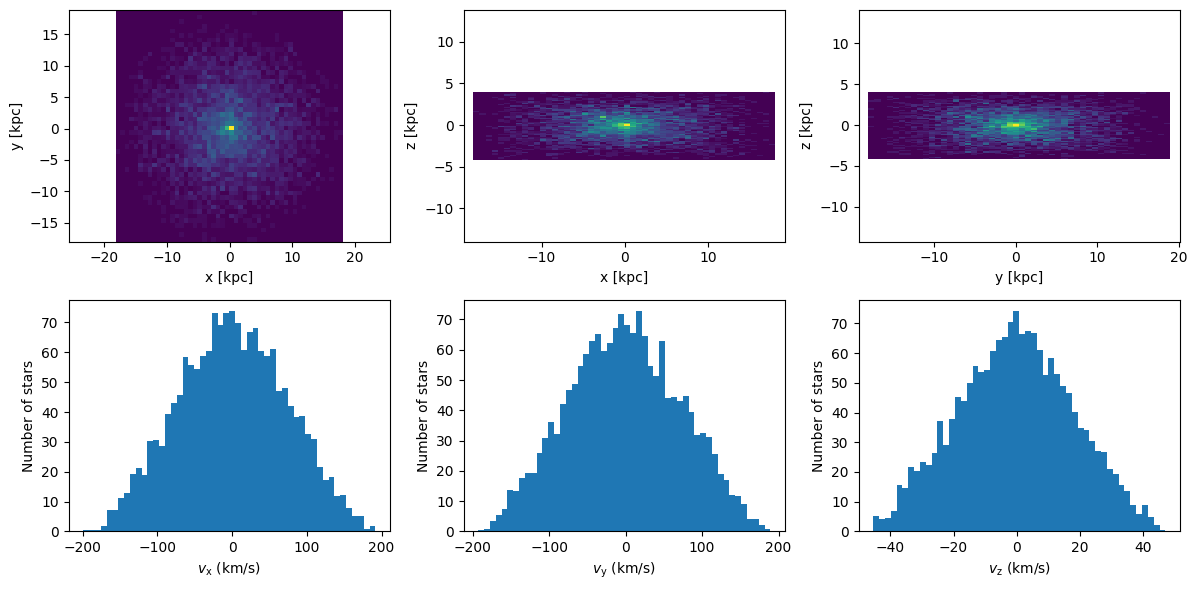

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.figure(figsize=(12,6))
plt.subplot(231)
plt.hist2d(x2, y2, bins=50, cmap="viridis", weights=soft_weights2)#, norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.axis('equal')
plt.subplot(232)
plt.hist2d(x2, z2, bins=50, cmap="viridis", weights=soft_weights2)
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.subplot(233)
plt.hist2d(y2, z2, bins=50, cmap="viridis", weights=soft_weights2)
plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')


plt.subplot(234)
plt.hist(v_x2, bins=50, weights=soft_weights2)#, range=(-2000, 2000))
plt.xlabel(r"$v_\text{x}$ (km/s)")
plt.ylabel("Number of stars")

plt.subplot(235)
plt.hist(v_y2, bins=50, weights=soft_weights2)#, range=(-2000, 2000))
plt.xlabel(r"$v_\text{y}$ (km/s)")
plt.ylabel("Number of stars")

plt.subplot(236)
plt.hist(v_z2, bins=50, weights=soft_weights2)
plt.xlabel(r"$v_\text{z}$ (km/s)")
plt.ylabel("Number of stars")
plt.tight_layout()
plt.show()

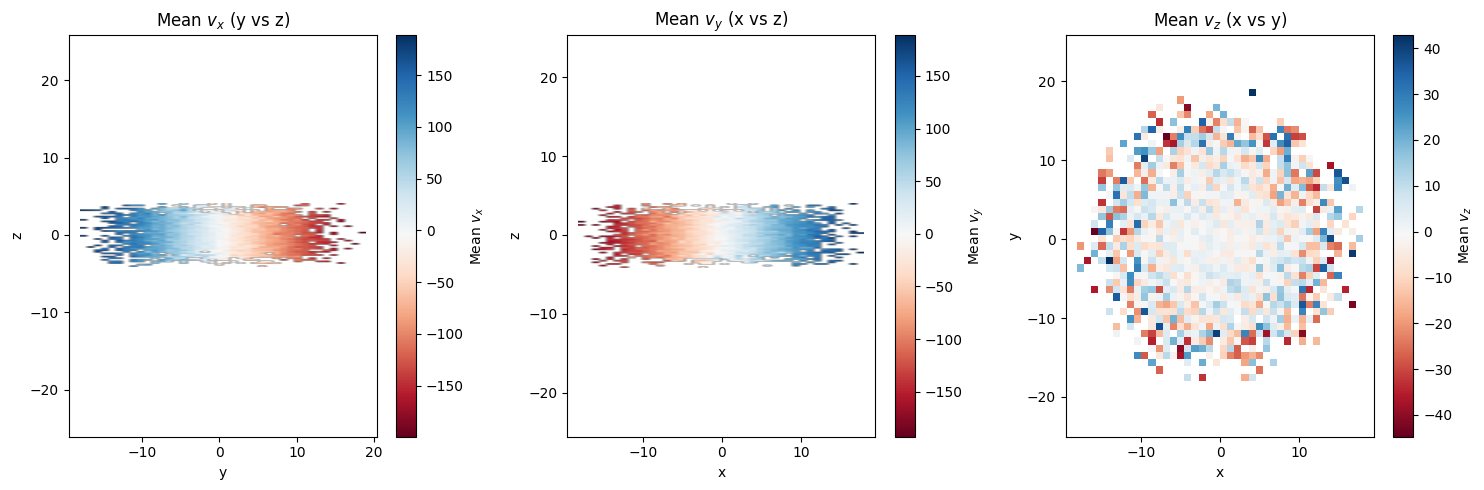

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import binned_statistic_2d

# Helper function to calculate weighted mean
def weighted_mean_2d(x_pos, y_pos, values, weights, x_bins, y_bins):
    # Sum of (value * weight) in each bin
    weighted_sum, _, _, _ = binned_statistic_2d(
        x_pos, y_pos, values * weights, statistic='sum', bins=[x_bins, y_bins]
    )
    # Sum of weights in each bin
    sum_of_weights, _, _, _ = binned_statistic_2d(
        x_pos, y_pos, weights, statistic='sum', bins=[x_bins, y_bins]
    )
    
    # Divide, handling division by zero (where sum_of_weights is 0)
    with np.errstate(divide='ignore', invalid='ignore'):
        result = weighted_sum / sum_of_weights
    
    return result

num_bins_x = 40
num_bins_y = 40
num_bins_z = 40 

# Example: x, z, v_y are 1D arrays of particle positions and velocities
# Define bin edges
x_bins = np.linspace(x2.min(), x2.max(), num_bins_x + 1)
y_bins = np.linspace(y2.min(), y2.max(), num_bins_y + 1)
z_bins = np.linspace(z2.min(), z2.max(), num_bins_z + 1)

# Digitize positions to bin indices
x_idx = np.digitize(x2, x_bins) - 1
y_idx = np.digitize(y2, y_bins) - 1
z_idx = np.digitize(z2, z_bins) - 1

# Initialize array for mean v_y
mean_vx = np.full((num_bins_y, num_bins_z), np.nan)
mean_vy = np.full((num_bins_x, num_bins_z), np.nan)
mean_vz = np.full((num_bins_x, num_bins_y), np.nan)

# 1. Mean v_x (y vs z)
mean_vx = weighted_mean_2d(y2, z2, v_x2, soft_weights2, y_bins, z_bins)

# 2. Mean v_y (x vs z)
mean_vy = weighted_mean_2d(x2, z2, v_y2, soft_weights2, x_bins, z_bins)

# 3. Mean v_z (x vs y)
mean_vz = weighted_mean_2d(x2, y2, v_z2, soft_weights2, x_bins, y_bins)

        
# Plot mean velocity maps side-by-side (y vs z, x vs z, x vs y)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# mean_vx: y vs z
im0 = axs[0].imshow(mean_vx.T, origin='lower', aspect='auto',
                   extent=[y_bins[0], y_bins[-1], z_bins[0], z_bins[-1]],
                   cmap='RdBu')
axs[0].set_xlabel('y')
axs[0].set_ylabel('z')
axs[0].set_title('Mean $v_x$ (y vs z)')
axs[0].axis('equal')
plt.colorbar(im0, ax=axs[0], label='Mean $v_x$')
# mean_vy: x vs z
im1 = axs[1].imshow(mean_vy.T, origin='lower', aspect='auto',
                   extent=[x_bins[0], x_bins[-1], z_bins[0], z_bins[-1]],
                   cmap='RdBu')
axs[1].set_xlabel('x')
axs[1].set_ylabel('z')
axs[1].set_title('Mean $v_y$ (x vs z)')
axs[1].axis('equal')
plt.colorbar(im1, ax=axs[1], label='Mean $v_y$')
# mean_vz: x vs y
im2 = axs[2].imshow(mean_vz.T, origin='lower', aspect='auto',
                   extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
                   cmap='RdBu')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Mean $v_z$ (x vs y)')
plt.colorbar(im2, ax=axs[2], label='Mean $v_z$')
axs[2].axis('equal')
plt.tight_layout()
plt.show()

# Combine disk and spheroid

In [12]:
x_tot = jnp.concatenate([x, x2])
y_tot = jnp.concatenate([y, y2])
z_tot = jnp.concatenate([z, z2])
v_x_tot = jnp.concatenate([v_x, v_x2])
v_y_tot = jnp.concatenate([v_y, v_y2])
v_z_tot = jnp.concatenate([v_z, v_z2])  
soft_weights_tot = jnp.concatenate([soft_weights, soft_weights2])

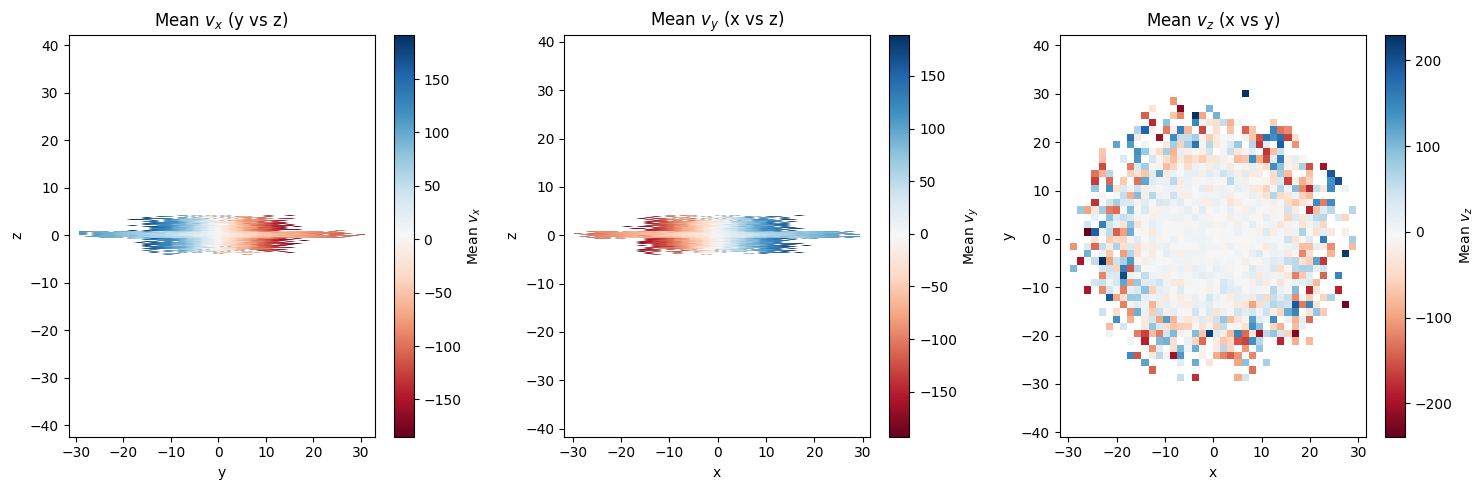

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import binned_statistic_2d

# Helper function to calculate weighted mean
def weighted_mean_2d(x_pos, y_pos, values, weights, x_bins, y_bins):
    # Sum of (value * weight) in each bin
    weighted_sum, _, _, _ = binned_statistic_2d(
        x_pos, y_pos, values * weights, statistic='sum', bins=[x_bins, y_bins]
    )
    # Sum of weights in each bin
    sum_of_weights, _, _, _ = binned_statistic_2d(
        x_pos, y_pos, weights, statistic='sum', bins=[x_bins, y_bins]
    )
    
    # Divide, handling division by zero (where sum_of_weights is 0)
    with np.errstate(divide='ignore', invalid='ignore'):
        result = weighted_sum / sum_of_weights
    
    return result

num_bins_x = 40
num_bins_y = 40
num_bins_z = 40 

# Example: x, z, v_y are 1D arrays of particle positions and velocities
# Define bin edges
x_bins = np.linspace(x_tot.min(), x_tot.max(), num_bins_x + 1)
y_bins = np.linspace(y_tot.min(), y_tot.max(), num_bins_y + 1)
z_bins = np.linspace(z_tot.min(), z_tot.max(), num_bins_z + 1)

# Digitize positions to bin indices
x_idx = np.digitize(x_tot, x_bins) - 1
y_idx = np.digitize(y_tot, y_bins) - 1
z_idx = np.digitize(z_tot, z_bins) - 1

# Initialize array for mean v_y
mean_vx = np.full((num_bins_y, num_bins_z), np.nan)
mean_vy = np.full((num_bins_x, num_bins_z), np.nan)
mean_vz = np.full((num_bins_x, num_bins_y), np.nan)

# 1. Mean v_x (y vs z)
mean_vx = weighted_mean_2d(y_tot, z_tot, v_x_tot, soft_weights_tot, y_bins, z_bins)

# 2. Mean v_y (x vs z)
mean_vy = weighted_mean_2d(x_tot, z_tot, v_y_tot, soft_weights_tot, x_bins, z_bins)

# 3. Mean v_z (x vs y)
mean_vz = weighted_mean_2d(x_tot, y_tot, v_z_tot, soft_weights_tot, x_bins, y_bins)

        
# Plot mean velocity maps side-by-side (y vs z, x vs z, x vs y)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# mean_vx: y vs z
im0 = axs[0].imshow(mean_vx.T, origin='lower', aspect='auto',
                   extent=[y_bins[0], y_bins[-1], z_bins[0], z_bins[-1]],
                   cmap='RdBu')
axs[0].set_xlabel('y')
axs[0].set_ylabel('z')
axs[0].set_title('Mean $v_x$ (y vs z)')
axs[0].axis('equal')
plt.colorbar(im0, ax=axs[0], label='Mean $v_x$')
# mean_vy: x vs z
im1 = axs[1].imshow(mean_vy.T, origin='lower', aspect='auto',
                   extent=[x_bins[0], x_bins[-1], z_bins[0], z_bins[-1]],
                   cmap='RdBu')
axs[1].set_xlabel('x')
axs[1].set_ylabel('z')
axs[1].set_title('Mean $v_y$ (x vs z)')
axs[1].axis('equal')
plt.colorbar(im1, ax=axs[1], label='Mean $v_y$')
# mean_vz: x vs y
im2 = axs[2].imshow(mean_vz.T, origin='lower', aspect='auto',
                   extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
                   cmap='RdBu')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Mean $v_z$ (x vs y)')
plt.colorbar(im2, ax=axs[2], label='Mean $v_z$')
axs[2].axis('equal')
plt.tight_layout()
plt.show()